# Evaluation of generated images by Stable Diffusion 1.5 & Dreambooth

The images were generated from the train set images using this Google Colab notebook:

**[[https://colab.research.google.com/github/ShivamShrirao/diffusers/blob/main/examples/dreambooth/DreamBooth_Stable_Diffusion.ipynb]]**

The notebook below was used for analysis, visualisation and evaluation of generated images.

## Imports

In [1]:
# general
import glob

# mathematics
import math
import numpy as np

from typing import List, Tuple

# image processing
import cv2
from skimage.metrics import structural_similarity
from deepface import DeepFace

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid

cmap = mpl.cm.Dark2.colors

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Models from the DeepFace library for the face recognition
deepface_models = [
    "ArcFace", # <-- second best performance, faster computational time
    "DeepID", # <-- second worst performance
    "Facenet",
    "Facenet512",
    "OpenFace", # <-- worst performance
    "SFace",
    "VGG-Face" # <-- best performance, the longest computational time
]

## Helper functions

In [3]:
def get_file_name(file_path: str) -> str:
    """
    This function takes a file path as input and returns the file name (without extension).

    :param file_path: str - The file path to extract the file name from
    :return: str - The file name (without extension)
    """
    file_path_components = file_path.split('/')
    file_name_and_extension = file_path_components[-1].rsplit('.', 1)
    return file_name_and_extension[0]

In [4]:
def get_img_path_list(img_dir: str) -> List[str]:
    """
    This function takes a directory path as input and returns a list of sorted file paths for all .jpg and .png images in the directory.

    :param img_dir: str - The directory path to get the image file paths from
    :return: List[str] - A sorted list of file paths for all .jpg and .png images in the directory
    """
    img_path_list = sorted([f for f in glob.glob(f"./{img_dir}/*.jpg")] +
                           [f for f in glob.glob(f"./{img_dir}/*.png")])
    return img_path_list

In [5]:
def get_img_name_list(img_dir: str) -> List[str]:
    """
    This function takes a directory path as input and returns a list of sorted image file names (without extensions) for all .jpg and .png images in the directory.

    :param img_dir: str - The directory path to get the image file names from
    :return: List[str] - A sorted list of image file names (without extensions) for all .jpg and .png images in the directory
    """
    img_path_list = get_img_path_list(img_dir)
    img_name_list = [get_file_name(f) for f in img_path_list]
    return img_name_list

In [6]:
def load_images(img_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    This function takes a directory path as input and returns a list of loaded and converted to grayscale images and a list of their respective file names (without extensions).

    :param img_dir: str - The directory path to load the images from
    :return: Tuple[List[np.ndarray], List[str]] - A list of loaded and converted to grayscale images and a list of their respective file names (without extensions)
    """
    img_path_list = get_img_path_list(img_dir)
    img_name_list = get_img_name_list(img_dir)

    images = []
    for img_path in img_path_list:
        # Load the image
        img = cv2.imread(img_path)
        images.append(img)
    return images, img_name_list

In [7]:
def img2gray(img: np.ndarray) -> np.ndarray:
    """
    This function converts an image from BGR to grayscale
    :param img: A 3-dimensional numpy array of th image
    :return: A 2D grayscale numpy array of the image
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [8]:
def adjust_dim(image: np.ndarray, dim: Tuple[int, int] = (500, 500)) -> np.ndarray:
    """
    This function takes an image as input and returns a resized image with the specified dimension.

    :param image: np.ndarray - An image to be resized
    :param dim: Tuple[int, int] - The desired dimension of the resized images (default: (500, 500))
    :return: np.ndarray - A resized image with the specified dimension
    """
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

In [9]:
def get_detected_face(img: np.ndarray) -> List[Tuple[int, int, int, int]]:
    """
    This function takes an image as input and returns a list of detected faces in the image represented as a list of tuples (x, y, width, height).

    :param img: np.ndarray - An image to detect faces in
    :return: List[Tuple[int, int, int, int]] - A list of detected faces in the image represented as a list of tuples (x, y, width, height)
    """
    alg = "haarcascade_frontalface_default.xml"
    haar_cascade = cv2.CascadeClassifier(alg)

    if img.ndim > 1:
        img = img2gray(img)

    face = haar_cascade.detectMultiScale(img, 1.3, 4)

    return face

In [10]:
def plot_images(images: List[np.ndarray], direction: str='h', img_line_len: int=4, figsize: Tuple[int,int]=(20,20), title: str=None, fontsize: int=12, title_color: str='black', space: Tuple[float, float]=(0.05, 0.05), plot_detected_face: bool=False):
    """
    This function plots images in a grid.
    :param images: List[np.ndarray] - A list of images to plot
    :param direction: str - The direction of the grid (h - horizontal, v - vertical)
    :param img_line_len: int - The number of images in each row (if direction is 'h') or in each column (if direction is 'v')
    :param figsize: Tuple[int, int] - The size of the figure
    :param title: str - The title of the figure
    :param fontsize: int - The font size of the title
    :param title_color: str - The color of the title
    :param space: Tuple[float, float] - The space between the subplots
    :param plot_detected_face: bool - Whether or not to detect the face in each image and plot a rectangle around it
    :return: None
    """
    n_images = len(images)
    cols = img_line_len
    rows = math.ceil(n_images / cols)

    if direction == 'v':
        tmp = cols
        cols = rows
        rows = tmp

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()

    for i, ax in enumerate(axs):
        if i < n_images:
            ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            ax.set_axis_off()

            if plot_detected_face == True:
                face = get_detected_face(images[i])
                for (x, y, w, h) in face:
                    ax.add_patch(Rectangle((x, y), w, h, edgecolor = 'red', fill=False, lw=3))

        else:
            fig.delaxes(ax)
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=space[0], hspace=space[1])

    if title:
        fig.suptitle(title, fontsize=fontsize, color=title_color, y=1.05)

In [11]:
def get_ssim_score(image1: np.ndarray, image2: np.ndarray) -> float:
    """
    This function takes two images as input and returns their Structural Similarity Index (SSIM) score.
    :param image1: np.ndarray - The first image
    :param image2: np.ndarray - The second image
    :return: float - The Structural Similarity Index (SSIM) score
    """
    # Convert the images to grayscale if not already done
    if image1.ndim > 2:
        image1 = img2gray(image1)
    if image2.ndim > 2:
        image2 = img2gray(image2)
    ssim = np.round(structural_similarity(image1, image2), 2)
    return ssim

In [12]:
def get_face_verification(image1: str, image2: str, model: str='VGG-Face') -> bool:
    """
    Given two image paths and a deep learning model name, return a boolean indicating
    whether the faces in the two images match.

    :param image1: The path to the first image.
    :param image2: The path to the second image.
    :param model: The name of the deep learning model to use for face verification.
    :return: A boolean indicating whether the faces in the two images match.
    """
    results = DeepFace.verify(img1_path = image1,
                              img2_path = image2,
                              model_name = model
                              )
    face_verified = results['verified']
    return face_verified

In [13]:
def get_metric_matrix(img_dir: str, metric: str='SSIM', model: str='VGG-Face', print_log: bool=False) -> np.ndarray:
    """
    Given an image directory and a comparison metric, return a matrix of similarity scores for all image pairs.

    :param img_dir: The path to the directory containing the images.
    :param metric: The comparison metric to use, either 'SSIM' or 'face_verification'.
    :param model: The name of the deep learning model to use for face verification, if `metric` is 'face_verification'.
    :param print_log: A boolean indicating whether to print log messages.
    :return: A matrix of similarity scores, where each entry is the score for a pair of images.
    """
    images, img_name_list = load_images(img_dir)

    adjusted_images = []
    for image in images:
        adjusted_image = adjust_dim(image, dim=(500, 500))
        adjusted_images.append(adjusted_image)
    n_images = len(adjusted_images)

    metric_matrix = np.empty((n_images, n_images))
    metric_matrix[:] = np.nan

    for i in np.arange(n_images):
        for j in np.arange(i, n_images):
            if print_log == True:
                print(f'{img_name_list[i]}, {img_name_list[j]}')
            if metric == 'SSIM':
                res = get_ssim_score(adjusted_images[i], adjusted_images[j])
            if metric == 'face_verification':
                res = get_face_verification(adjusted_images[i], adjusted_images[j], model=model)
            if print_log == True:
                print(res)
            metric_matrix[j, i] = res
    return metric_matrix

In [14]:
def get_cross_metric_matrix(img_dir_1: str, img_dir_2: str, metric: str='SSIM', model: str='VGG-Face', print_log: bool=False) -> np.ndarray:
    """
    Given two image directories and a comparison metric, return a matrix of similarity scores for all image pairs.

    :param img_dir_1: The path to the first directory containing the images.
    :param img_dir_2: The path to the second directory containing the images.
    :param metric: The comparison metric to use, either 'SSIM' or 'face_verification'.
    :param model: The name of the deep learning model to use for face verification, if `metric` is 'face_verification'.
    :param print_log: A boolean indicating whether to print log messages.
    :return: A matrix of similarity scores, where each entry is the score for a pair of images.
    """
    images_1, img_name_list_1 = load_images(img_dir_1)
    adjusted_images_1 = []
    for image in images_1:
        adjusted_image = adjust_dim(image, dim=(500, 500))
        adjusted_images_1.append(adjusted_image)
    n_images_1 = len(images_1)

    images_2, img_name_list_2 = load_images(img_dir_2)
    adjusted_images_2 = []
    for image in images_2:
        adjusted_image = adjust_dim(image, dim=(500, 500))
        adjusted_images_2.append(adjusted_image)
    n_images_2 = len(images_2)

    metric_matrix = np.empty((n_images_1, n_images_2))
    metric_matrix[:] = np.nan

    for i in np.arange(n_images_1):
        for j in np.arange(n_images_2):
            if print_log == True:
                print(f'{img_name_list_1[i]}, {img_name_list_2[j]}')
            if metric == 'SSIM':
                res = get_ssim_score(adjusted_images_1[i], adjusted_images_2[j])
            if metric == 'face_verification':
                res = get_face_verification(adjusted_images_1[i], adjusted_images_2[j], model=model)
            if print_log == True:
                print(res)
            metric_matrix[i, j] = res
    return metric_matrix

In [15]:
def plot_metric_matrix(metric_matrix: np.ndarray,
                       img_name_list: list,
                       img_name_list_2: list = [],
                       metric: str = 'SSIM',
                       show_metric_scores: bool = False):
    """
    Plot the given metric matrix as a heatmap and display the average score.

    :param metric_matrix: A 2D numpy array representing the pairwise comparison of metrics.
    :param img_name_list: A list of strings representing the names of the images on the y-axis of the plot.
    :param img_name_list_2: A list of strings representing the names of the images on the x-axis of the plot. Defaults to `img_name_list`.
    :param metric: A string representing the type of metric being plotted. Defaults to 'SSIM'.
    :param show_metric_scores: A boolean indicating whether the individual metric scores should be displayed on the plot. Defaults to False.
    :return: None
    """

    ave_score = np.round(np.nansum(metric_matrix)/metric_matrix.size, 2)

    if img_name_list_2 == []:
        img_name_list_2 = img_name_list
        ave_score = np.round(((np.nansum(metric_matrix)-len(metric_matrix))/((metric_matrix.size - len(metric_matrix))/2)), 2)


    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 1),
                     direction='row', axes_pad=0.05,
                     label_mode='1', share_all=False,
                     cbar_location='right', cbar_mode='single',
                     cbar_size='10%', cbar_pad=0.05)

    ax = grid[0]
    ax.set_title(f'Pairwise {metric} scores, ave = {ave_score}', fontsize=30)
    ax.tick_params(axis='both', direction='out', labelsize=14)
    im = ax.imshow(metric_matrix, interpolation='nearest', vmax=1, vmin=0)
    ax.cax.colorbar(im)

    ax.cax.tick_params(labelsize=14)
    ax.set_xticks(np.arange(metric_matrix.shape[1]))
    ax.set_xticklabels(img_name_list_2, rotation = 90)
    ax.set_yticks(np.arange(metric_matrix.shape[0]))
    ax.set_yticklabels(img_name_list)

    ax.grid(False)

    if show_metric_scores == True:
        for i in range(metric_matrix.shape[0]):
            for j in range(metric_matrix.shape[1]):
                text = ax.text(j, i, np.round(metric_matrix[i, j],1),
                               ha="center", va="center", color="w", size=16)

    plt.show()

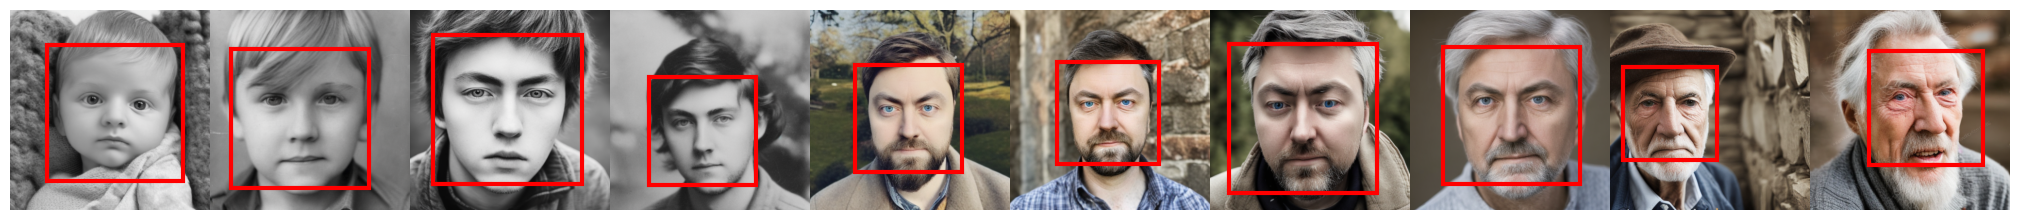

In [16]:
# Load all images from the directory
img_dir = "results/dfast_adult_01_best/"
images, img_name_list = load_images(img_dir)

# adjust all images to 500 x 500 dimensions
adjusted_images = []
for image in images:
    adjusted_image = adjust_dim(image, dim=(500, 500))
    adjusted_images.append(adjusted_image)

# Plot the images in a grid
plot_images(adjusted_images, direction='h', img_line_len=10, space=(0.0, 0.0), plot_detected_face=True)

## Evaluation of the generated images

In [17]:
train_dfast_child_01 = 'dfast/SD_datasets/dfast_child_01'
train_dfast_child_02 = 'dfast/SD_datasets/dfast_child_02'
train_dfast_adult_01 = 'dfast/SD_datasets/dfast_adult_01'
train_dfast_adult_02 = 'dfast/SD_datasets/dfast_adult_02'
train_dfast_all_01 = 'dfast/SD_datasets/dfast_all_01'
train_dfast_all_02 = 'dfast/SD_datasets/dfast_all_02'

train_dir_list = [train_dfast_child_01,
                  train_dfast_child_02,
                  train_dfast_adult_01,
                  train_dfast_adult_02,
                  train_dfast_all_01,
                  train_dfast_all_02]

res_dfast_child_01 = 'results/dfast_child_01'
res_dfast_child_02 = 'results/dfast_child_02'
res_dfast_adult_01 = 'results/dfast_adult_01'
res_dfast_adult_02 = 'results/dfast_adult_02'
dfast_all_01 = 'results/dfast_all_01'
dfast_all_02 = 'results/dfast_all_02'

res_dir_list = [res_dfast_child_01,
                res_dfast_child_02,
                res_dfast_adult_01,
                res_dfast_adult_02,
                dfast_all_01,
                dfast_all_02]

res_dir = dfast_all_02

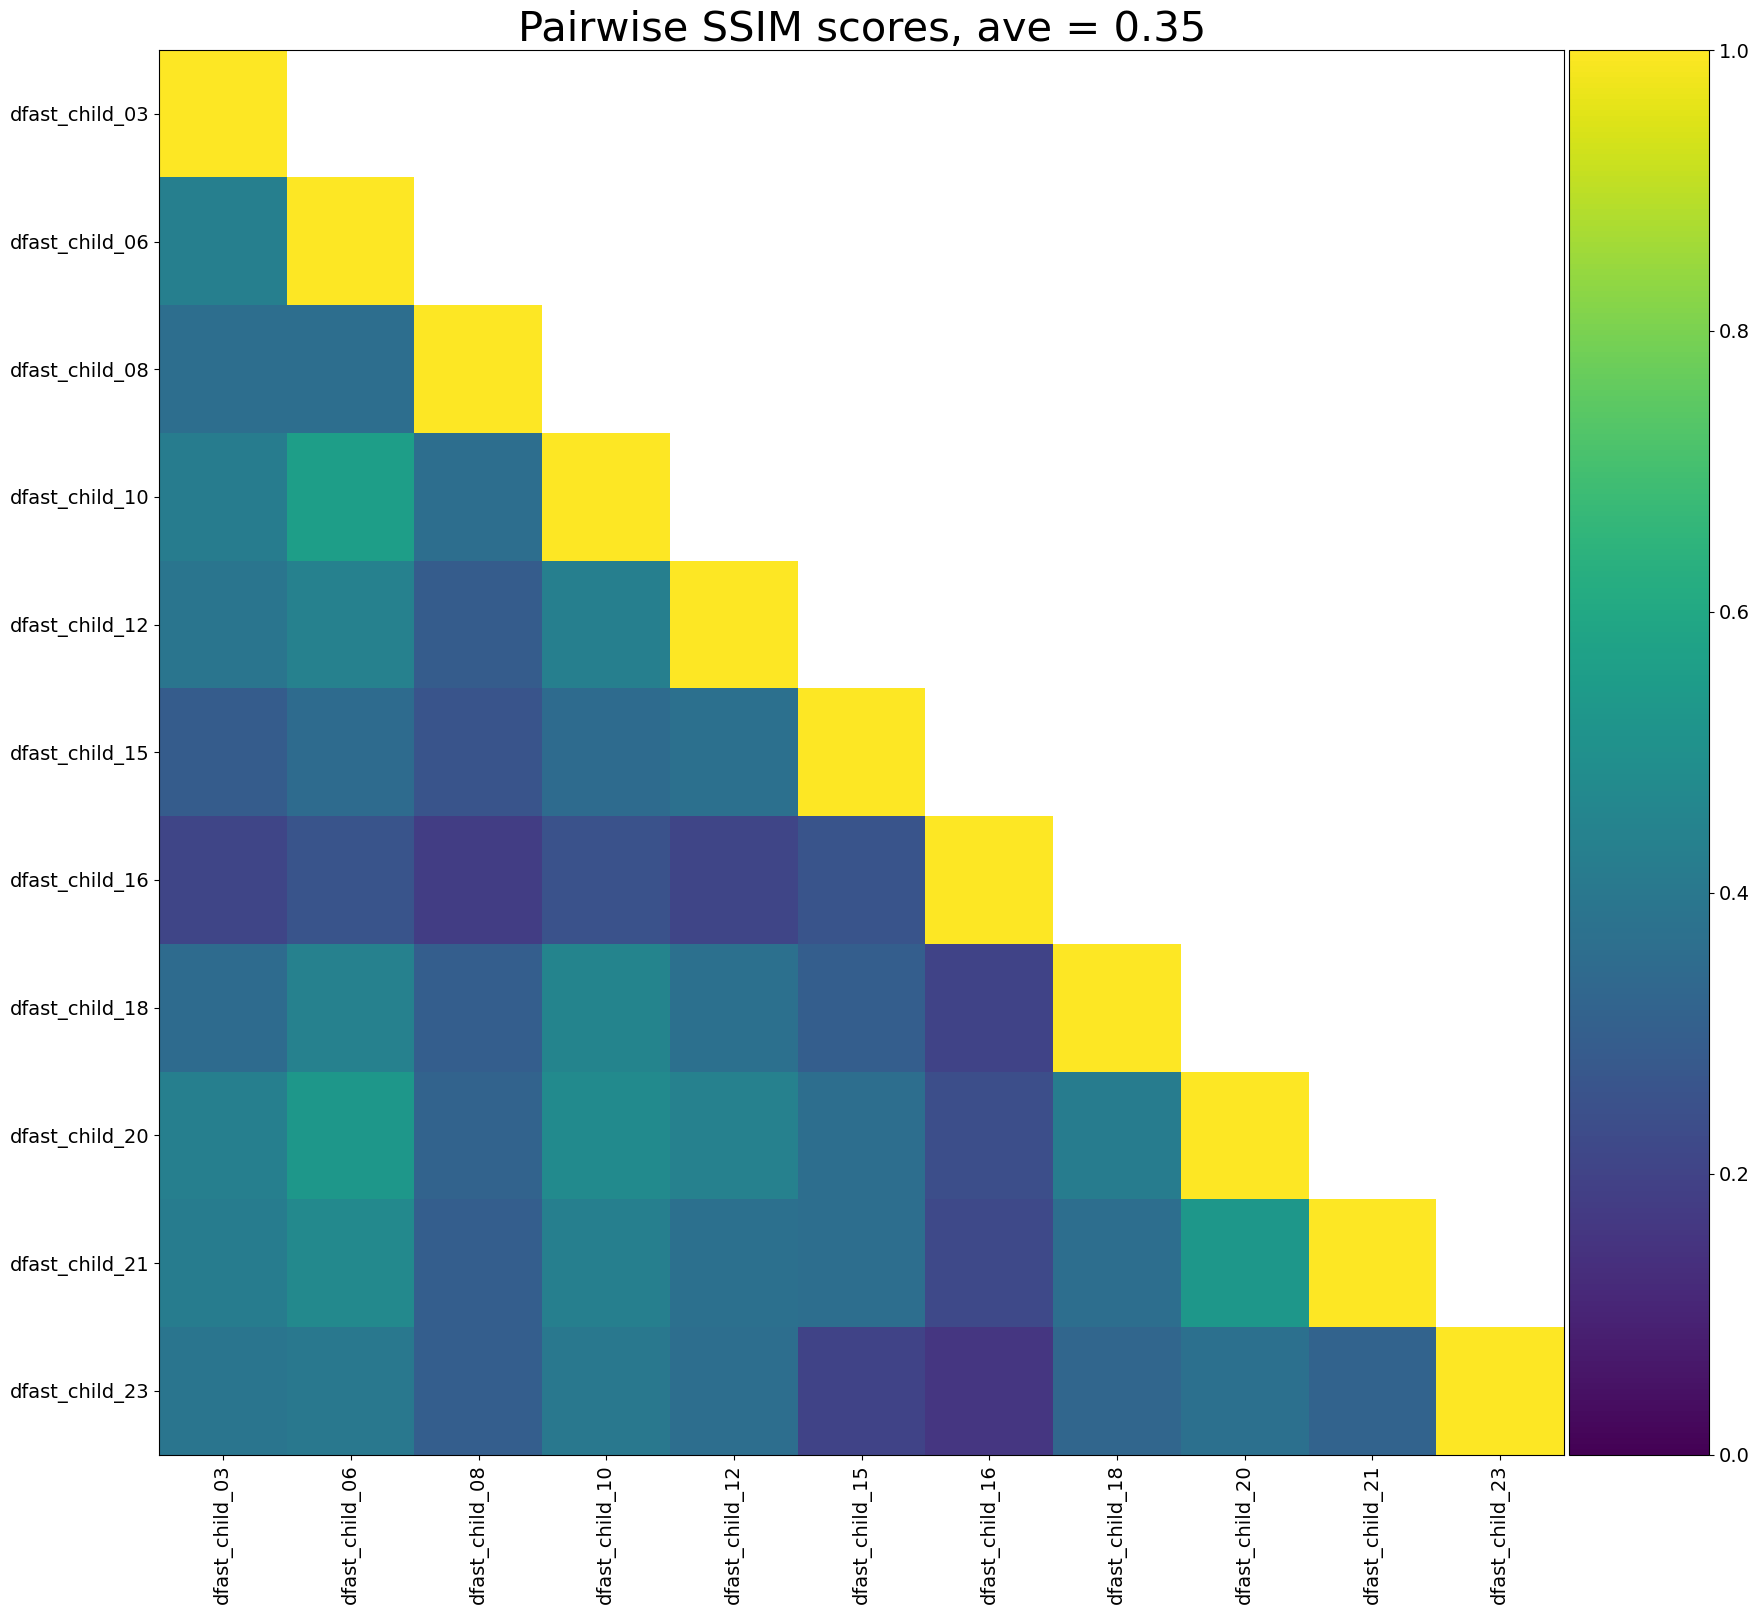

In [18]:
metric_matrix = get_metric_matrix(train_dfast_child_01, metric='SSIM')
plot_metric_matrix(metric_matrix, img_name_list=get_img_name_list(train_dfast_child_01))

results/dfast_child_01 vs. results/dfast_child_01


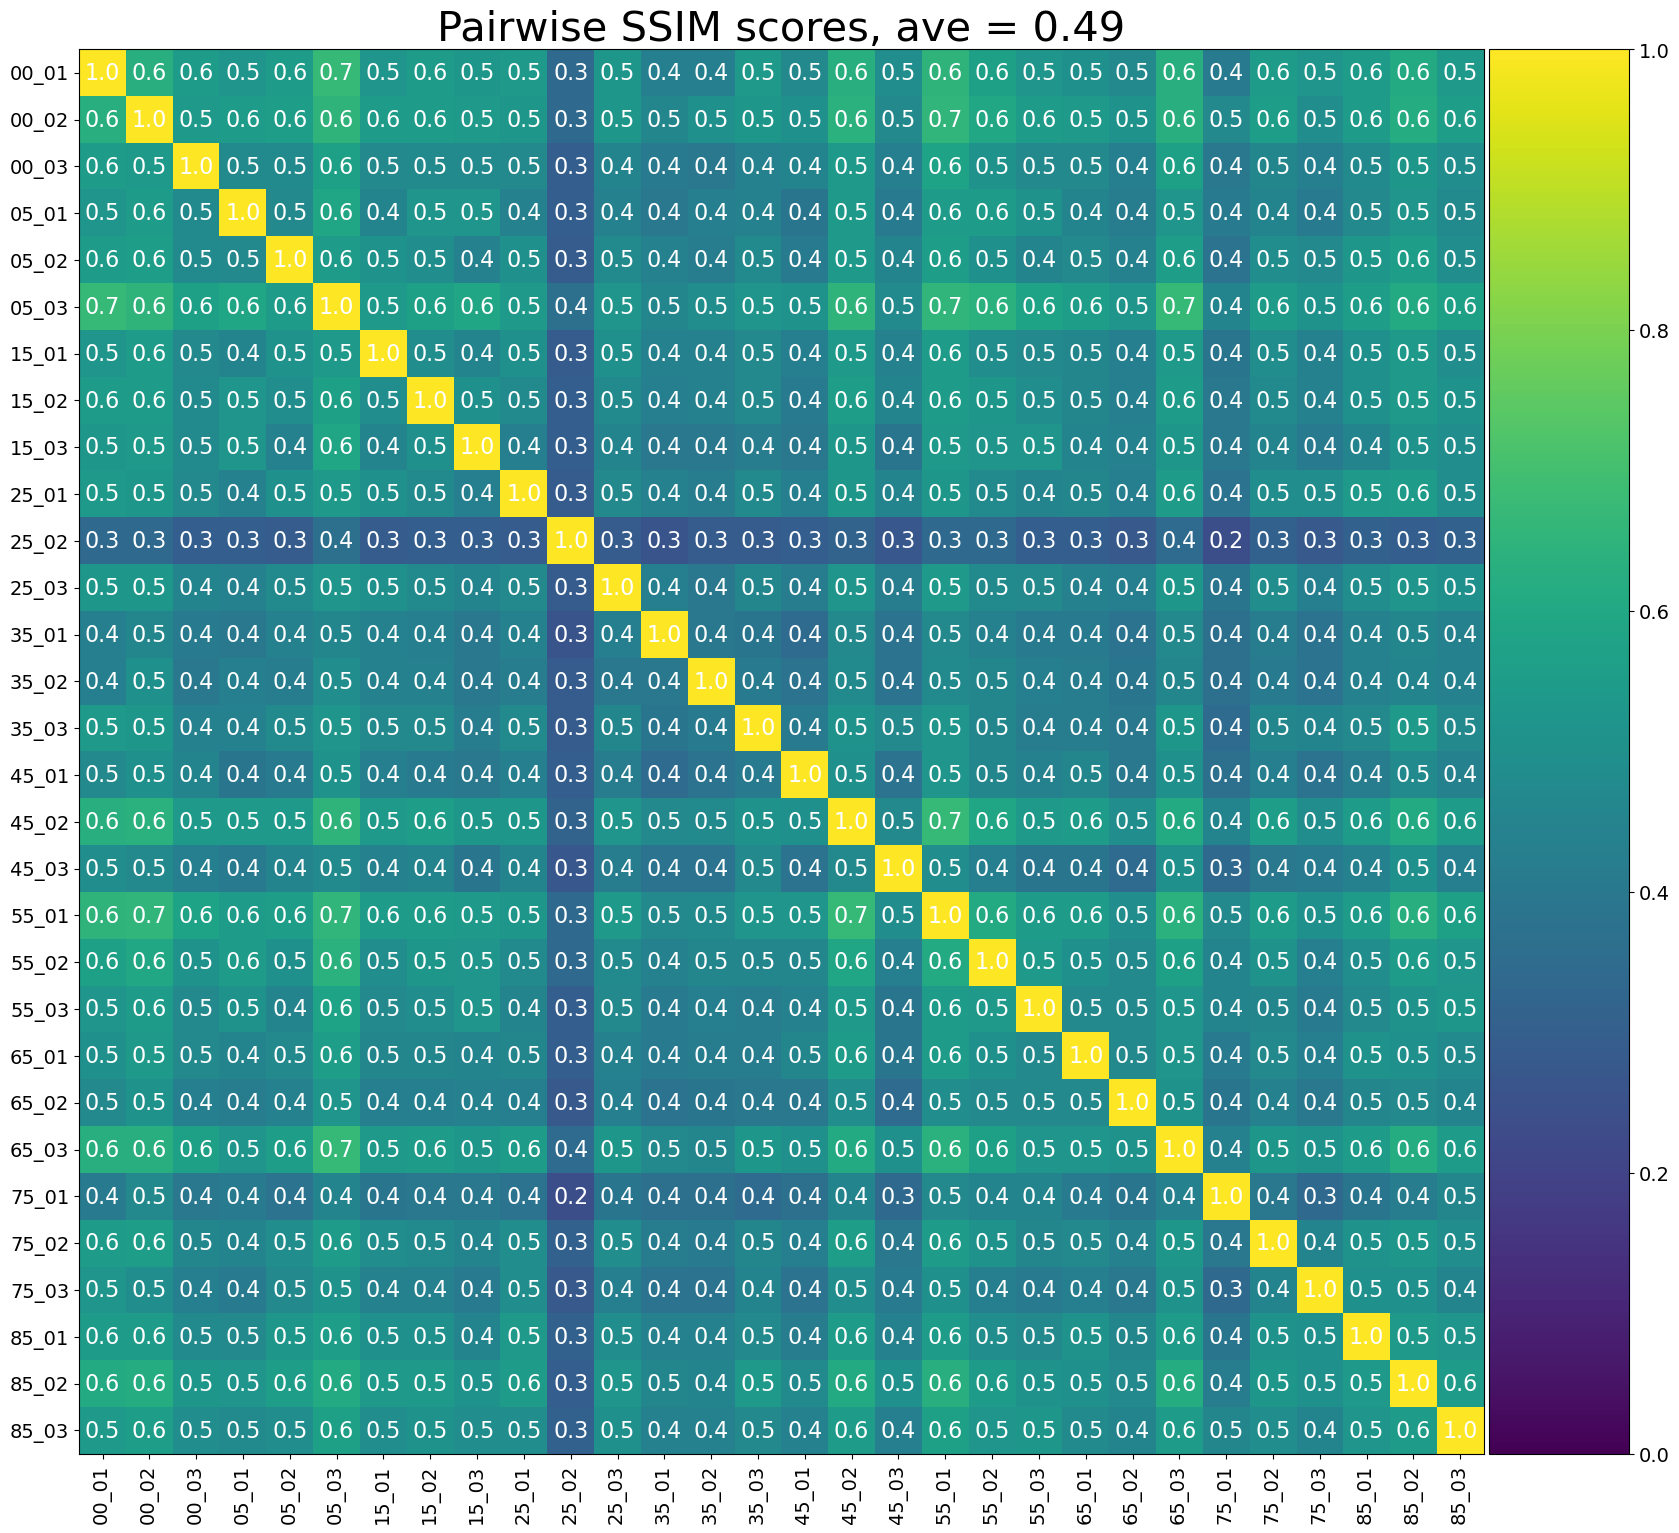

results/dfast_child_01 vs. results/dfast_child_02


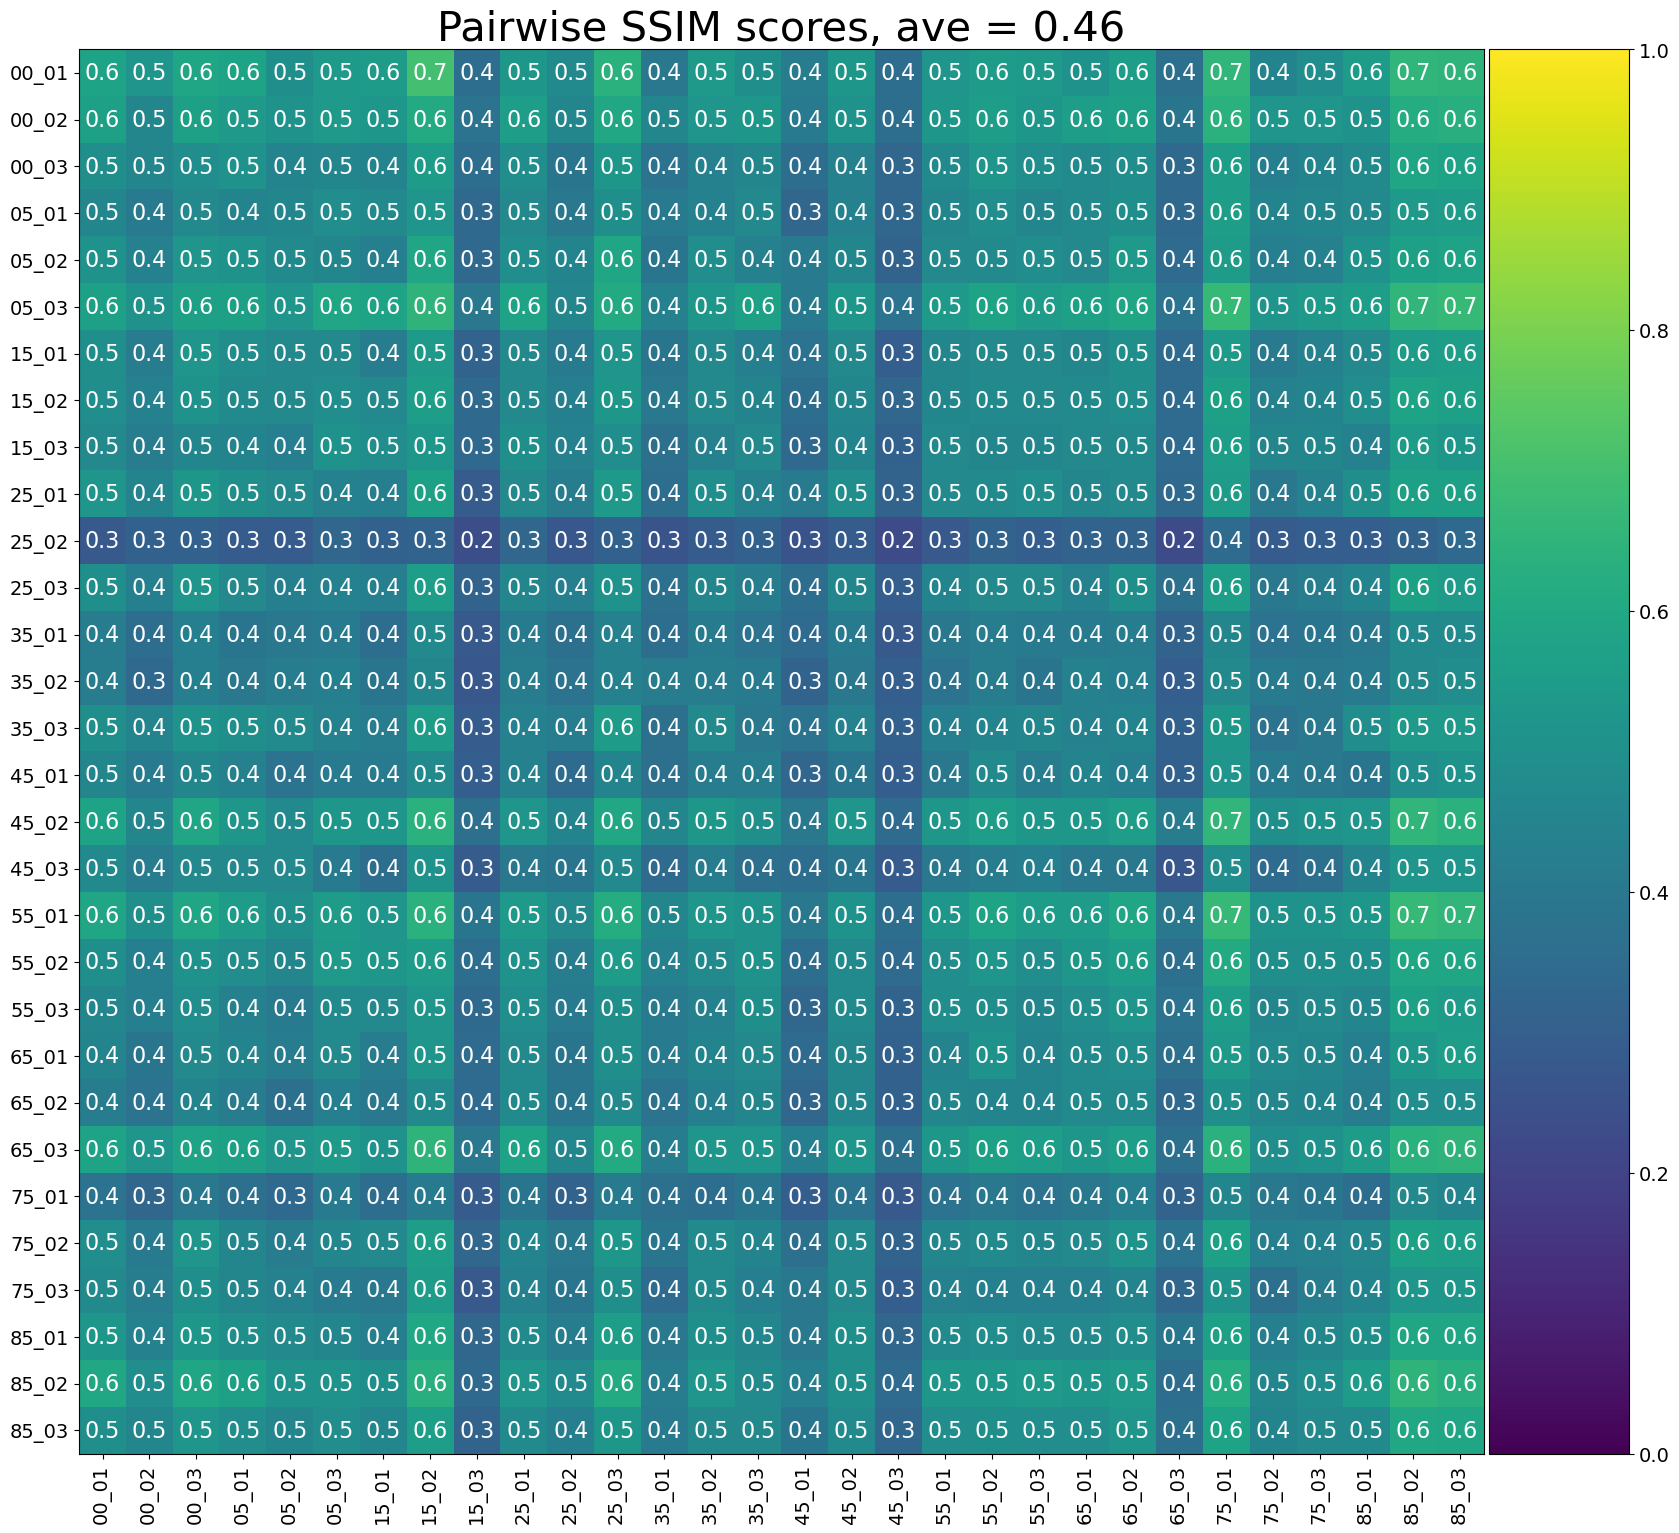

results/dfast_child_02 vs. results/dfast_child_02


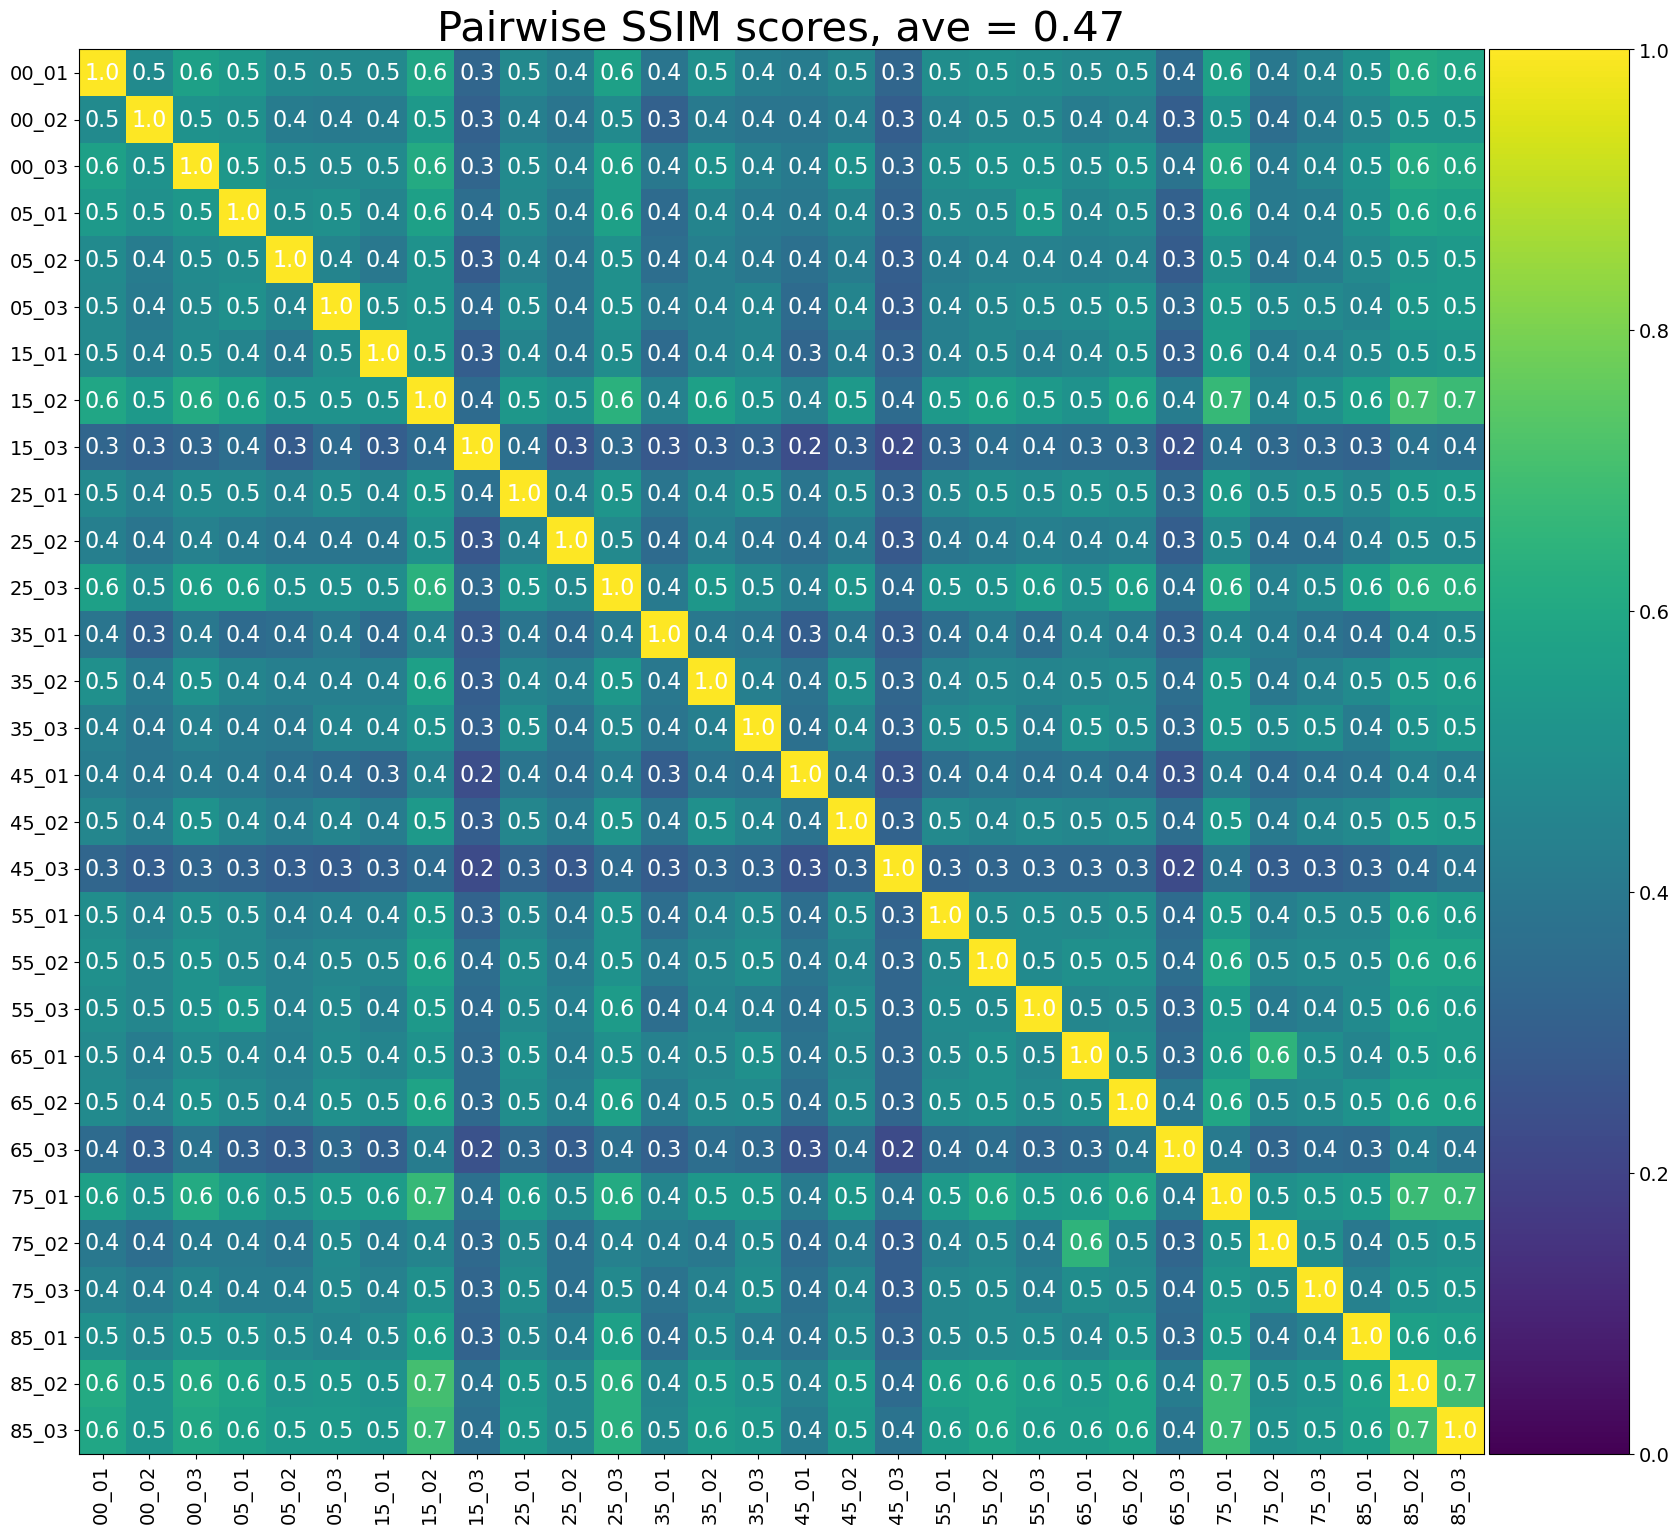

In [19]:
n_dir = len(res_dir_list[:2])
for i in np.arange(n_dir):
    for j in np.arange(i, n_dir):
        print(f'{res_dir_list[i]} vs. {res_dir_list[j]}')
        metric_matrix_train = get_cross_metric_matrix(img_dir_1=res_dir_list[i],
                                                      img_dir_2=res_dir_list[j],
                                                      metric='SSIM')
        plot_metric_matrix(metric_matrix_train,
                           img_name_list=get_img_name_list(res_dir_list[i]),
                           img_name_list_2=get_img_name_list(res_dir_list[j]),
                           metric='SSIM',
                           show_metric_scores=True)

results/dfast_child_01 vs. results/dfast_child_01


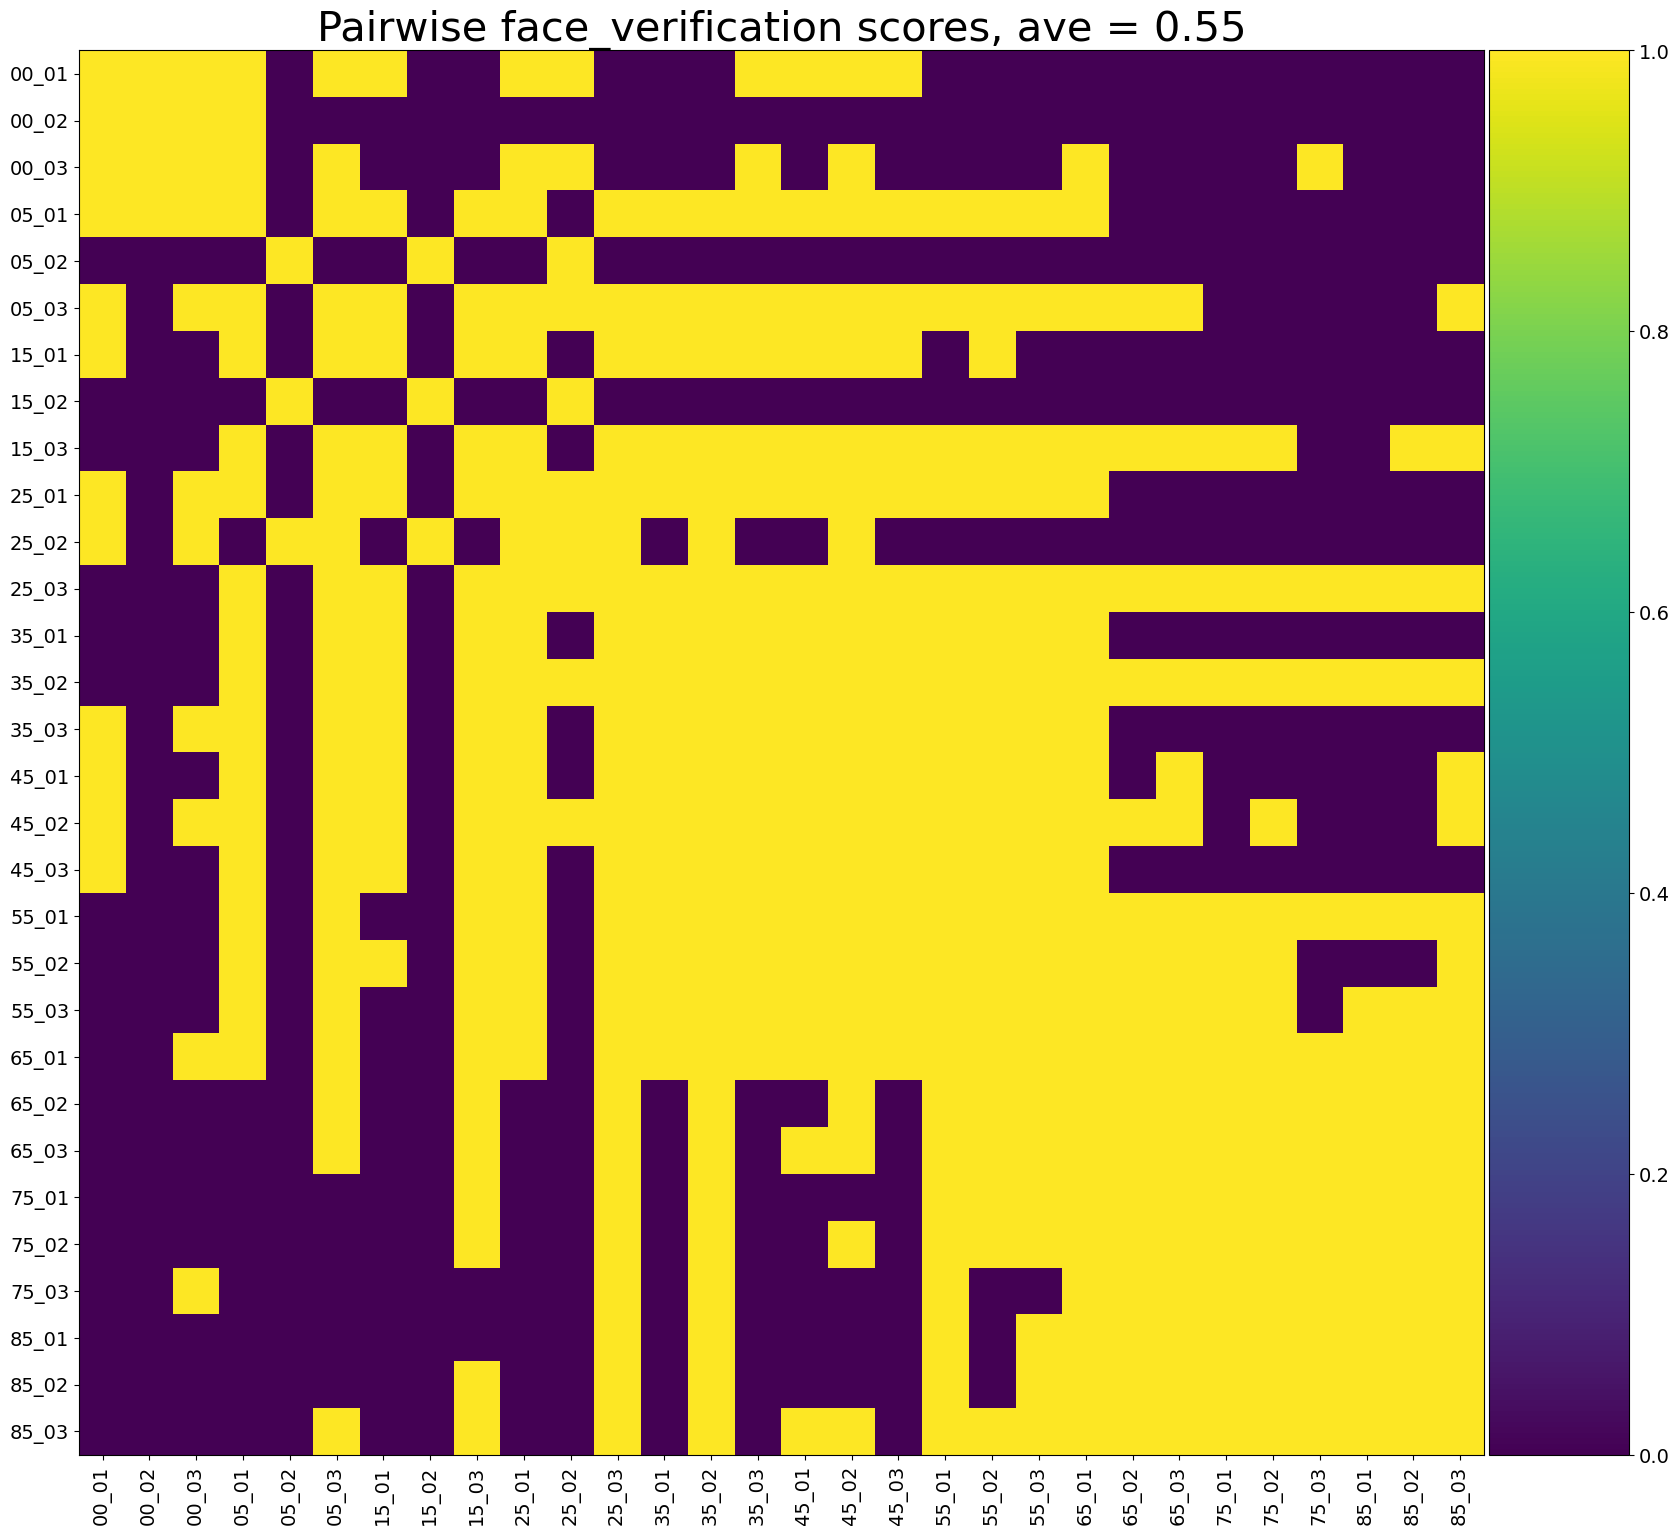

results/dfast_child_01 vs. results/dfast_child_02


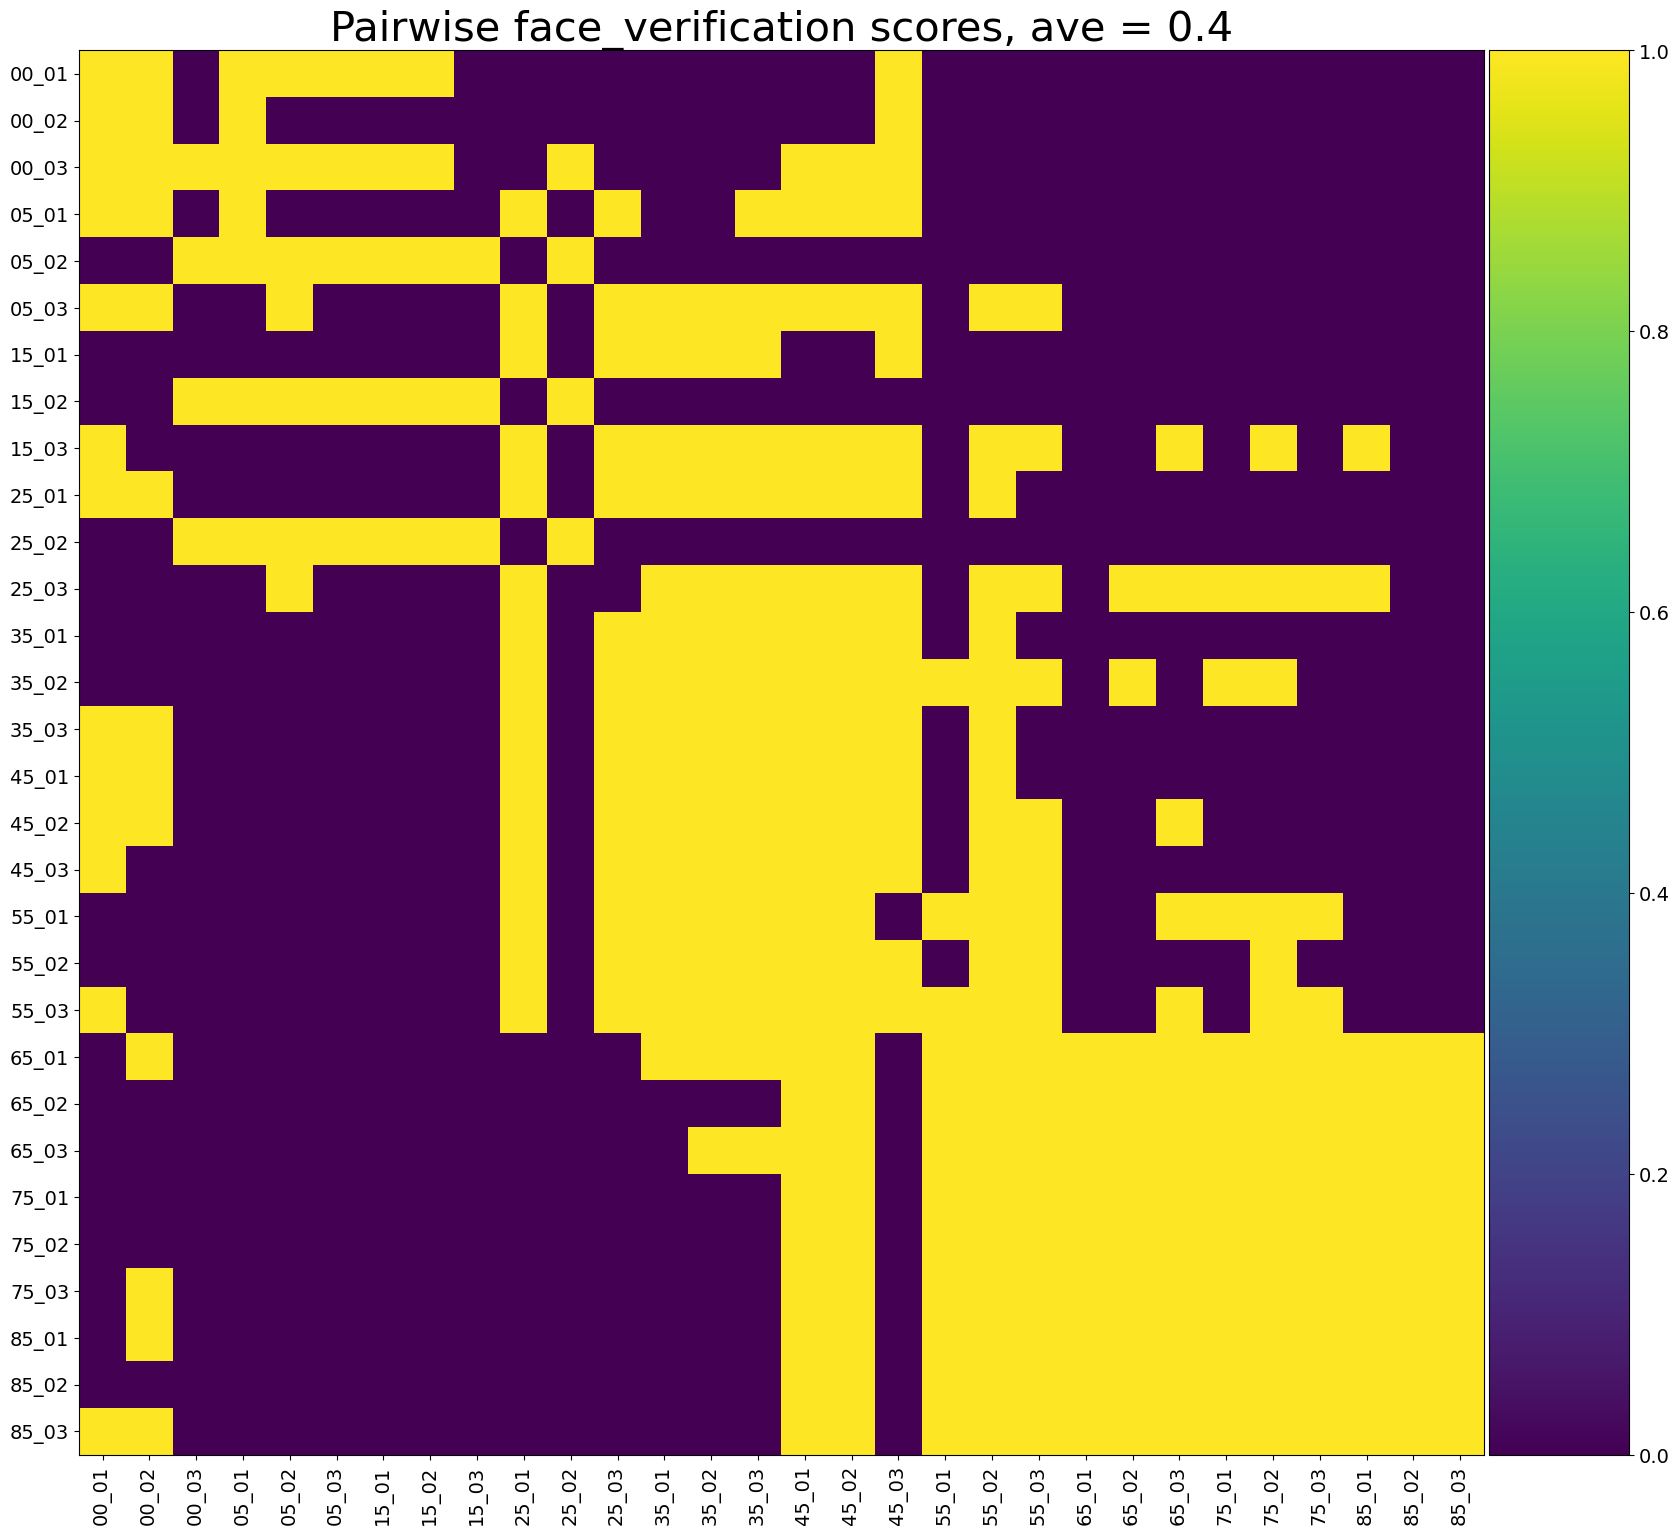

results/dfast_child_02 vs. results/dfast_child_02


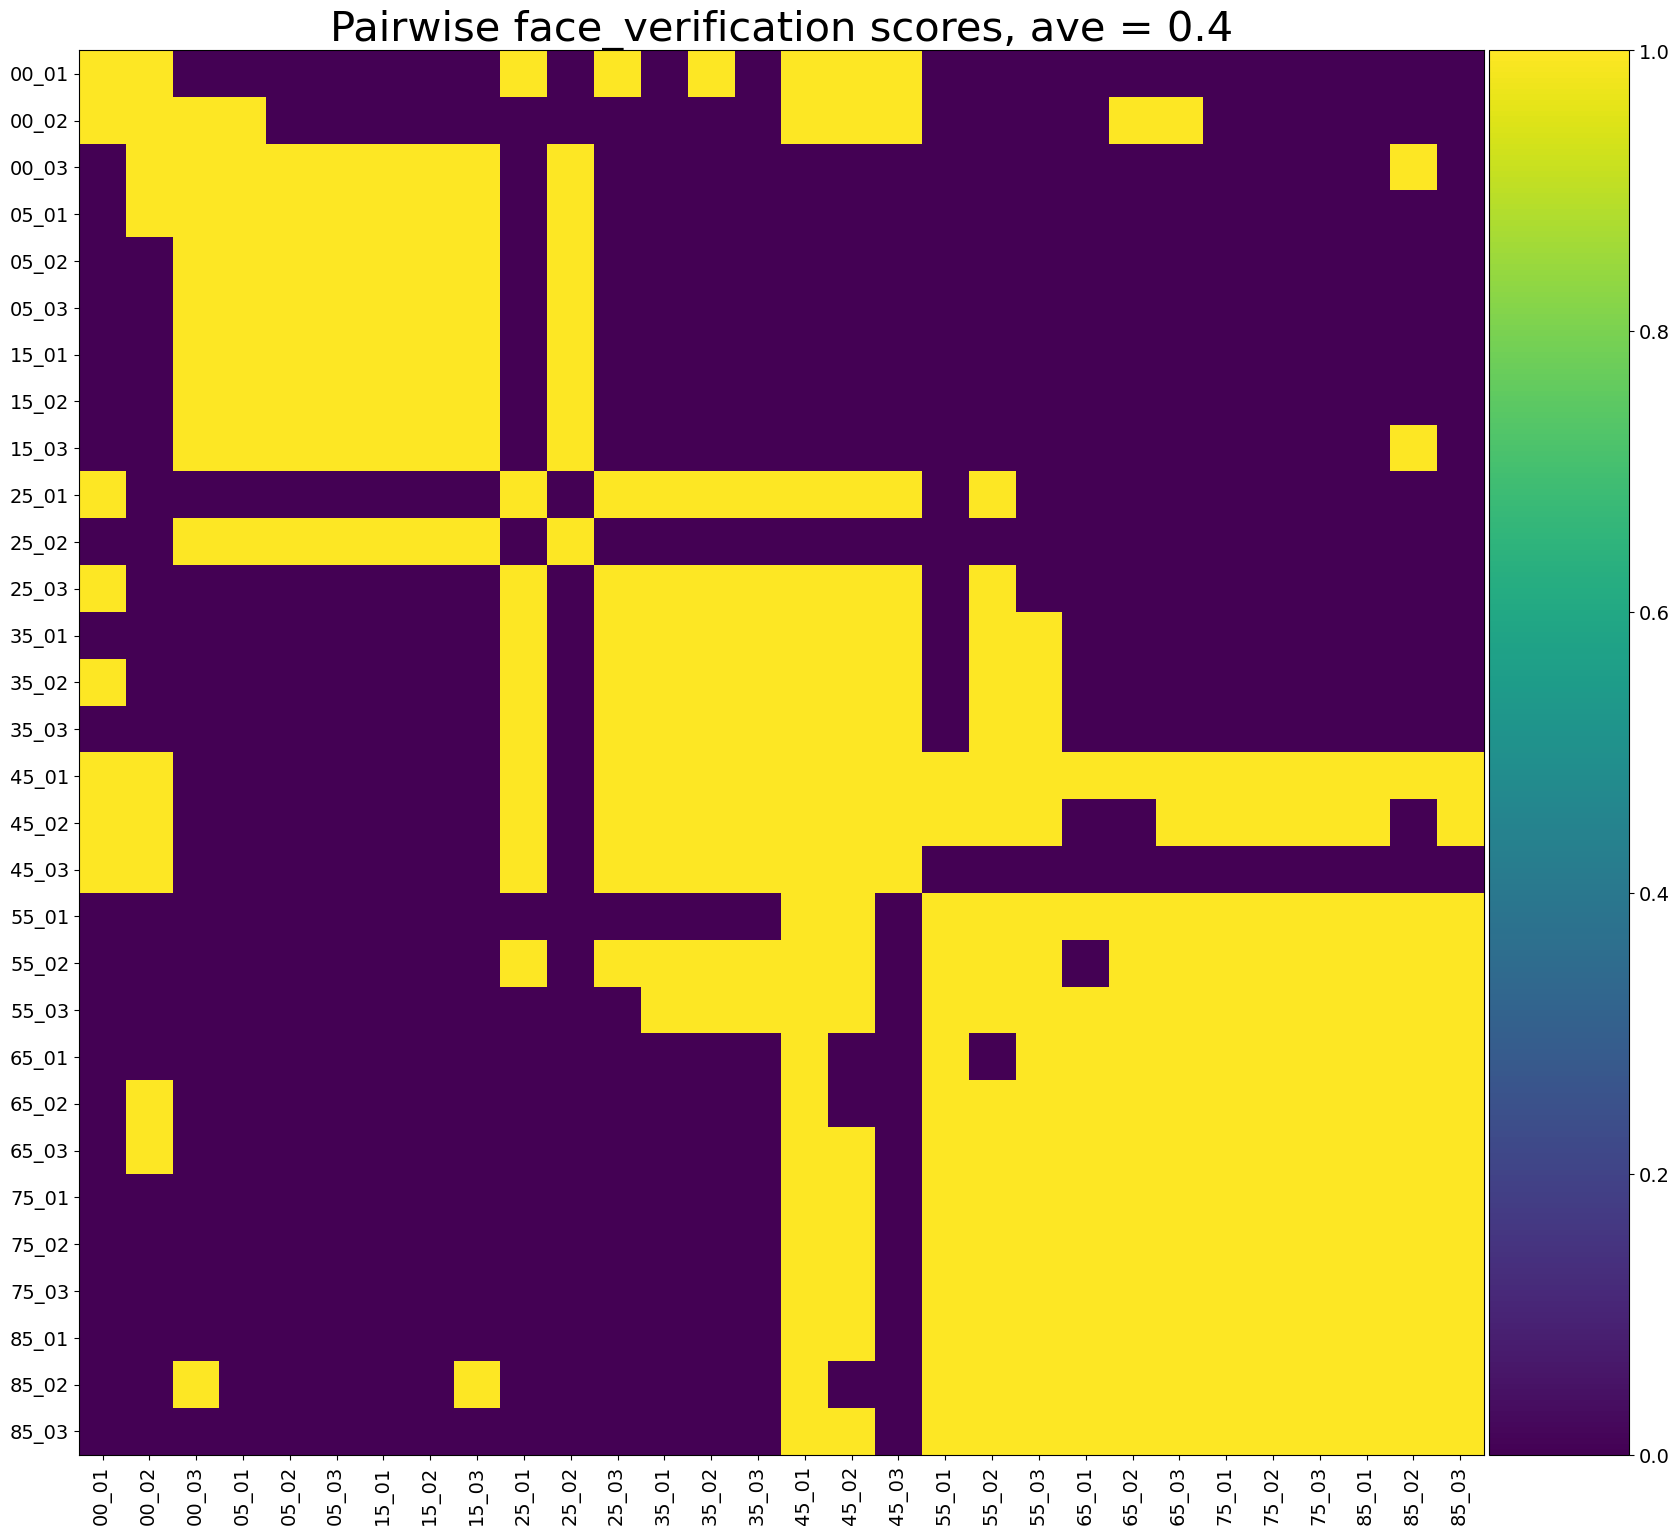

In [20]:
n_dir = len(res_dir_list[:2])
for i in np.arange(n_dir):
    for j in np.arange(i, n_dir):
        print(f'{res_dir_list[i]} vs. {res_dir_list[j]}')
        metric_matrix = get_cross_metric_matrix(img_dir_1=res_dir_list[i],
                                                      img_dir_2=res_dir_list[j],
                                                      metric='face_verification')
        plot_metric_matrix(metric_matrix,
                           img_name_list=get_img_name_list(res_dir_list[i]),
                           img_name_list_2=get_img_name_list(res_dir_list[j]),
                           metric='face_verification',
                           show_metric_scores=False)

In [ ]:
train_dir_list = [train_dfast_child_01,
                  train_dfast_adult_01,
                  train_dfast_all_01]

n_train_dir = len(train_dir_list)
n_res_dir = len(res_dir_list)

for i in np.arange(n_train_dir):
    for j in np.arange(n_res_dir):
        print(f'{train_dir_list[i]} vs. {res_dir_list[j]}')
        metric_matrix = get_cross_metric_matrix(img_dir_1=train_dir_list[i],
                                                img_dir_2=res_dir_list[j],
                                                metric='face_verification')
        plot_metric_matrix(metric_matrix,
                           img_name_list=get_img_name_list(train_dir_list[i]),
                           img_name_list_2=get_img_name_list(res_dir_list[j]),
                           metric='face_verification',
                           show_metric_scores=False)